In [21]:
import torch
from vision_tower import VGGT_OriAny_Ref
import os
from app_utils import *
from paths import *

device = 'cuda:0'

mark_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
model = VGGT_OriAny_Ref(
                out_dim     = 900,
                dtype       = mark_dtype,
                nopretrain  = True
            )

ckpt = torch.load(LOCAL_CKPT_PATH, map_location='cpu')
# ckpt = torch.load('verwoIN3D0.pt', map_location='cpu')

model.load_state_dict(ckpt)
model.eval()
model = model.to(device)
image_root  = '/mnt/workspace/muang/repos/OriAnyV2_Train/demo/'

print('load over')



load over


In [2]:
import rembg
from PIL import Image, ImageOps
from typing import Any, Optional, List, Dict, Union
from torchvision import transforms as TF
import torch.nn.functional as F

rembg_session = rembg.new_session()

def load_and_preprocess_images(image_path_list, mode="crop"):
    """
    A quick start function to load and preprocess images for model input.
    This assumes the images should have the same shape for easier batching, but our model can also work well with different shapes.

    Args:
        image_path_list (list): List of paths to image files
        mode (str, optional): Preprocessing mode, either "crop" or "pad".
                             - "crop" (default): Sets width to 518px and center crops height if needed.
                             - "pad": Preserves all pixels by making the largest dimension 518px
                               and padding the smaller dimension to reach a square shape.

    Returns:
        torch.Tensor: Batched tensor of preprocessed images with shape (N, 3, H, W)

    Raises:
        ValueError: If the input list is empty or if mode is invalid

    Notes:
        - Images with different dimensions will be padded with white (value=1.0)
        - A warning is printed when images have different shapes
        - When mode="crop": The function ensures width=518px while maintaining aspect ratio
          and height is center-cropped if larger than 518px
        - When mode="pad": The function ensures the largest dimension is 518px while maintaining aspect ratio
          and the smaller dimension is padded to reach a square shape (518x518)
        - Dimensions are adjusted to be divisible by 14 for compatibility with model requirements
    """
    # Check for empty list
    if len(image_path_list) == 0:
        raise ValueError("At least 1 image is required")
    
    # Validate mode
    if mode not in ["crop", "pad"]:
        raise ValueError("Mode must be either 'crop' or 'pad'")

    images = []
    shapes = set()
    to_tensor = TF.ToTensor()
    target_size = 518

    # First process all images and collect their shapes
    for item in image_path_list:
        if isinstance(item, Image.Image):
            img = item  # 已经是 PIL Image，直接使用
        else:
            img = Image.open(item)  # 否则认为是路径，打开它

        # If there's an alpha channel, blend onto white background:
        if img.mode == "RGBA":
            # Create white background
            background = Image.new("RGBA", img.size, (255, 255, 255, 255))
            # Alpha composite onto the white background
            img = Image.alpha_composite(background, img)

        # Now convert to "RGB" (this step assigns white for transparent areas)
        img = img.convert("RGB")

        width, height = img.size
        
        if mode == "pad":
            # Make the largest dimension 518px while maintaining aspect ratio
            if width >= height:
                new_width = target_size
                new_height = round(height * (new_width / width) / 14) * 14  # Make divisible by 14
            else:
                new_height = target_size
                new_width = round(width * (new_height / height) / 14) * 14  # Make divisible by 14
        else:  # mode == "crop"
            # Original behavior: set width to 518px
            new_width = target_size
            # Calculate height maintaining aspect ratio, divisible by 14
            new_height = round(height * (new_width / width) / 14) * 14

        # Resize with new dimensions (width, height)
        img = img.resize((new_width, new_height), Image.Resampling.BICUBIC)
        img = to_tensor(img)  # Convert to tensor (0, 1)

        # Center crop height if it's larger than 518 (only in crop mode)
        if mode == "crop" and new_height > target_size:
            start_y = (new_height - target_size) // 2
            img = img[:, start_y : start_y + target_size, :]
        
        # For pad mode, pad to make a square of target_size x target_size
        if mode == "pad":
            h_padding = target_size - img.shape[1]
            w_padding = target_size - img.shape[2]
            
            if h_padding > 0 or w_padding > 0:
                pad_top = h_padding // 2
                pad_bottom = h_padding - pad_top
                pad_left = w_padding // 2
                pad_right = w_padding - pad_left
                
                # Pad with white (value=1.0)
                img = torch.nn.functional.pad(
                    img, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=1.0
                )

        shapes.add((img.shape[1], img.shape[2]))
        images.append(img)

    # Check if we have different shapes
    # In theory our model can also work well with different shapes
    if len(shapes) > 1:
        print(f"Warning: Found images with different shapes: {shapes}")
        # Find maximum dimensions
        max_height = max(shape[0] for shape in shapes)
        max_width = max(shape[1] for shape in shapes)

        # Pad images if necessary
        padded_images = []
        for img in images:
            h_padding = max_height - img.shape[1]
            w_padding = max_width - img.shape[2]

            if h_padding > 0 or w_padding > 0:
                pad_top = h_padding // 2
                pad_bottom = h_padding - pad_top
                pad_left = w_padding // 2
                pad_right = w_padding - pad_left

                img = torch.nn.functional.pad(
                    img, (pad_left, pad_right, pad_top, pad_bottom), mode="constant", value=1.0
                )
            padded_images.append(img)
        images = padded_images

    images = torch.stack(images)  # concatenate images

    # Ensure correct shape when single image
    if len(image_path_list) == 1:
        # Verify shape is (1, C, H, W)
        if images.dim() == 3:
            images = images.unsqueeze(0)

    return images

def remove_background(image: Image, rembg_session: Any=None, force: bool = False, **rembg_kwargs) -> Image :
    do_remove = True
    if image.mode == 'RGBA' and image.getextrema()[3][0] < 255:
        do_remove = False
    do_remove = do_remove or force
    if do_remove:
        image = rembg.remove(image, session = rembg_session, **rembg_kwargs)
    return image


from scipy.special import i0
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
from functools import partial

def von_mises_pdf_alpha_numpy(alpha, x, mu, kappa):
    normalization = 2 * np.pi
    pdf = np.exp(kappa * np.cos(alpha * (x - mu))) / normalization
    return pdf

def val_fit_alpha(distribute):
    fit_alphas = []
    for y_noise in distribute:
        x = np.linspace(0, 2 * np.pi, 360)
        y_noise /= trapezoid(y_noise, x) + 1e-8
        
        initial_guess = [x[np.argmax(y_noise)], 1]

        alphas = [1.0, 2.0, 4.0]
        saved_params = []
        saved_r_squared = []

        for alpha in alphas:
            try:
                von_mises_pdf_alpha_partial = partial(von_mises_pdf_alpha_numpy, alpha)
                params, covariance = curve_fit(von_mises_pdf_alpha_partial, x, y_noise, p0=initial_guess)

                residuals = y_noise - von_mises_pdf_alpha_partial(x, *params)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y_noise - np.mean(y_noise))**2)
                r_squared = 1 - (ss_res / (ss_tot+1e-8))

                saved_params.append(params)
                saved_r_squared.append(r_squared)
                if r_squared > 0.8:
                    break
            except:
                saved_params.append((0.,0.))
                saved_r_squared.append(0.)

        max_index = np.argmax(saved_r_squared)
        alpha = alphas[max_index]
        mu_fit, kappa_fit = saved_params[max_index]
        r_squared = saved_r_squared[max_index]
        
        print(alpha, mu_fit, kappa_fit, r_squared)
        if alpha == 1. and kappa_fit>=0.5 and r_squared>=0.5:
            pass
        elif alpha == 2. and kappa_fit>=0.35 and r_squared>=0.35:
            pass
        elif alpha == 4. and kappa_fit>=0.25 and r_squared>=0.25:
            pass
        else:
            alpha=0.
        fit_alphas.append(alpha)
    return torch.tensor(fit_alphas)

@torch.no_grad()
def ref_single(ref_name, tgt_name, remove_bkg = True, softmax = False):
    ref_img = Image.open(ref_name)
    tgt_img = Image.open(tgt_name)
    if remove_bkg:
        ref_img = remove_background(ref_img, rembg_session, force=True)
        tgt_img = remove_background(tgt_img, rembg_session, force=True)
    
    batch_img_inputs = load_and_preprocess_images([ref_img, tgt_img], mode="pad")
        
    batch_img_inputs = batch_img_inputs.unsqueeze(0).to(device)
    # print(batch_img_inputs.shape)
    B, S, C, H, W = batch_img_inputs.shape
    pose_enc = model(batch_img_inputs) # (B, S, D) S = 1

    pose_enc = pose_enc.view(B*S, -1)

    angle_az_pred = torch.argmax(pose_enc[:, 0:360]       , dim=-1)
    angle_el_pred = torch.argmax(pose_enc[:, 360:360+180] , dim=-1) - 90
    angle_ro_pred = torch.argmax(pose_enc[:, 360+180:360+180+360] , dim=-1) - 180
    if softmax:
        alpha_pred = val_fit_alpha(distribute = F.softmax(pose_enc[:, 0:360], dim=-1).cpu().float().numpy())
    else:
        alpha_pred = val_fit_alpha(distribute = F.sigmoid(pose_enc[:, 0:360]).cpu().float().numpy())

    ori_az = (angle_az_pred.reshape(B,S)[:,0]).cpu().float().numpy()
    ori_el = (angle_el_pred.reshape(B,S)[:,0]).cpu().float().numpy()
    ori_ro = (angle_ro_pred.reshape(B,S)[:,0]).cpu().float().numpy()
    rel_az = (angle_az_pred.reshape(B,S)[:,1]).cpu().float().numpy()
    rel_el = (angle_el_pred.reshape(B,S)[:,1]).cpu().float().numpy()
    rel_ro = (angle_ro_pred.reshape(B,S)[:,1]).cpu().float().numpy()
    
    print('ori_az', ori_az)
    print('ori_el', ori_el)
    print('ori_ro', ori_ro)
    print('alpha' , alpha_pred)
    print('rel_az', rel_az)
    print('rel_el', rel_el)
    print('rel_ro', rel_ro)
    
    # return pose_enc
    
    return ori_az, ori_el, ori_ro, alpha_pred, rel_az, rel_el, rel_ro, pose_enc

@torch.no_grad()
def ori_single(ref_name, remove_bkg = True, softmax=True):
    ref_img = Image.open(ref_name)
    if remove_bkg:
        ref_img = remove_background(ref_img, rembg_session, force=True)

    batch_img_inputs = load_and_preprocess_images([ref_img], mode="pad")
    
    batch_img_inputs = batch_img_inputs.unsqueeze(0).to(device)
    # print(batch_img_inputs.shape)
    B, S, C, H, W = batch_img_inputs.shape
    pose_enc = model(batch_img_inputs) # (B, S, D) S = 1

    pose_enc = pose_enc.view(B*S, -1)
    gaus_az_pred   = pose_enc[:, 0:360]
    gaus_el_pred   = pose_enc[:, 360:360+180]
    gaus_ro_pred   = pose_enc[:, 360+180:360+180+360]
    
    
    if softmax:
        gaus_az_pred = F.relu(gaus_az_pred)
        gaus_el_pred = F.relu(gaus_el_pred)
        gaus_ro_pred = F.relu(gaus_ro_pred)
        gaus_az_pred = F.softmax(gaus_az_pred)
        gaus_el_pred = F.softmax(gaus_el_pred)
        gaus_ro_pred = F.softmax(gaus_ro_pred)

    angle_az_pred = (torch.argmax(gaus_az_pred, dim=-1)).cpu().float().numpy()
    angle_el_pred = (torch.argmax(gaus_el_pred, dim=-1) - 90).cpu().float().numpy()
    angle_ro_pred = (torch.argmax(gaus_ro_pred, dim=-1) - 180).cpu().float().numpy()

    alpha_pred = val_fit_alpha(distribute = F.sigmoid(gaus_az_pred).cpu().float().numpy())
    
    print('ori_az', angle_az_pred)
    print('ori_el', angle_el_pred)
    print('ori_ro', angle_ro_pred)
    print('alpha' , alpha_pred)

    # return pose_enc
    return angle_az_pred, angle_el_pred, angle_ro_pred, alpha_pred, pose_enc

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def vis_distribution(image_paths, dists, titles=None, save_path=None):
    dists = dists.cpu()
    n_samples = len(image_paths)
    
    # 创建子图：每行 2 列（img + plot），高度自适应
    fig, axes = plt.subplots(n_samples, 2, figsize=(10, 3 * n_samples))
    if n_samples == 1:
        axes = [axes]  # 统一维度

    x = np.arange(360)  # 0 到 359

    for row in range(n_samples):
        img_path = image_paths[row]
        ax_img = axes[row][0] if n_samples > 1 else axes[0][0]
        ax_plot = axes[row][1] if n_samples > 1 else axes[0][1]

        # --- 显示图像 ---
        img = plt.imread(img_path)
        ax_img.imshow(img)
        ax_img.set_title(titles[row] if titles else f"Image {row+1}")
        ax_img.axis('on')  # 保留坐标轴（显示刻度和边框）
        ax_img.set_xticks([])
        ax_img.set_yticks([])
        # 可选：保留边框
        for spine in ax_img.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color('black')

        # --- 显示分布 ---
        ref_dis = dists[row][:360].float().numpy()
        ax_plot.plot(x, ref_dis, color='blue', linewidth=1.5)

        ax_plot.set_title(f"Azimuth {row+1}")
        ax_plot.set_xlabel("Angle (degrees)")
        ax_plot.set_ylabel("Value")
        ax_plot.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path != None:
        plt.savefig(save_path, format='jpg', dpi=300, bbox_inches='tight')
    plt.show()



1.0 6.335738976087225 0.3758221538851055 0.46655786181987247
ori_az [349.]
ori_el [11.]
ori_ro [0.]
alpha tensor([0.])


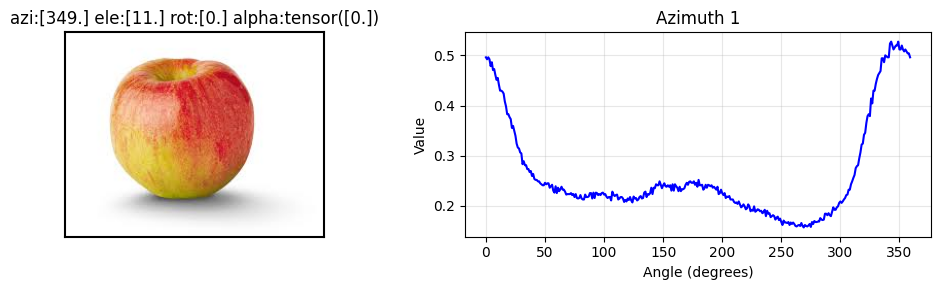

In [23]:
# image_paths = ['./test_demo/lion.jpg']
# image_paths = ['./test_demo/bowl.jpg']
# save_path = './test_demo_output/bowl.jpg'
# image_paths = ['./test_demo/coin2.jpg', './test_demo/coin3.jpg']
# image_paths = ['./test_demo/coin2.jpg']
# save_path = './test_demo_output/coin.jpg'

# image_paths = ['./test_demo/F22-0.jpg', './test_demo/F22-1.jpg']
# save_path = './test_demo_output/F22.jpg'

# image_paths = ['./test_demo/F22-1.jpg']
# save_path = './test_demo_output/F22.jpg'

# image_paths = ['./test_demo/handbag6.jpg']
# save_path = './test_demo_output/handbag.jpg'

# image_paths = ['./test_demo/bottle.jpg']
# save_path = './test_demo_output/bottle.jpg'

image_paths = ['./test_demo/apple.jpg']
save_path = './test_demo_output/apple.jpg'

# image_paths = ['./test_demo/pot.jpg', './test_demo/pot2.jpg']
# save_path = './test_demo_output/pot.jpg'

if len(image_paths) == 1:
    ori_az, ori_el, ori_ro, alpha_pred, pose_enc = ori_single(image_paths[0], True, False)
    titles = [f'azi:{ori_az} ele:{ori_el} rot:{ori_ro} alpha:{alpha_pred}']
else:
    ori_az, ori_el, ori_ro, alpha_pred, rel_az, rel_el, rel_ro, pose_enc = ref_single(image_paths[0], image_paths[1], False, False)
    titles = [f'azi:{ori_az} ele:{ori_el} rot:{ori_ro} alpha:{alpha_pred}', f'azi:{rel_az} ele:{rel_el} rot:{rel_ro}']

vis_distribution(image_paths, F.sigmoid(pose_enc), titles, save_path)